In [1]:
%matplotlib inline

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # version 2.1 or higher required!

# To make life easy, we've released some code for working with the predictions - let's import that first.
from zoobot.estimators import concentration_utils, losses, dirichlet_stats
from zoobot import label_metadata

In [3]:
os.chdir('/home/walml/repos/zoobot')

In [4]:
ml_loc = 'results/temp/decals_n2_allq_m0_all.csv'  # load the predictions (only one model here)
ml = pd.read_csv(ml_loc)
print('Galaxies with ML predictions: ' + str(len(ml)))

Galaxies with ML predictions: 309398


In [5]:
concentration_cols = [a + '_concentration' for a in label_metadata.decals_label_cols]

In [6]:
concentrations = concentration_utils.load_all_concentrations(ml, concentration_cols)
concentrations.shape

(309398, 34, 5)

These are the predictions themselves - dirichlet concentrations for each (galaxy, answer, forward pass). These define posteriors for the number of responses per answer. You can visualise the posteriors like so:

In [7]:
# TODO

Many people will be happy to just use the posterior means as a 'best guess' prediction. We release these precalculated, but should you wish to repeat or tweak the calculation, here's how to do it:

In [8]:
# TODO refactor this into release package
def apply_over_questions(concentrations, question_index_groups, func):
    results = []
    for q_n in range(len(question_index_groups)):
        q_indices = question_index_groups[q_n]
        q_start = q_indices[0]
        q_end = q_indices[1]
        q_result = func(concentrations[:, q_start:q_end+1])
        results.append(q_result)
    
    results = np.concatenate(results, axis=1)
    return results  # leave the reduce_sum to the estimator

def mean_for_answers(concentrations_for_q, total_votes):
     return dirichlet_stats.DirichletEqualMixture(total_votes, concentrations_for_q).mean()

Create a Schema object describing the decision tree. 

In [9]:
schema = losses.Schema(label_metadata.decals_label_cols, label_metadata.decals_questions, version='decals')
# could refactor to get_decals_schema

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


In [30]:
func = lambda x: mean_for_answers(x, np.ones(len(x)))  # the mean prediction for one answer per question is the predicted fraction of volunteers giving each answer

# mean_answers = apply_over_questions(concentrations, schema.question_index_groups, func)  # calculate the mean prediction for every question
mean_answers = apply_over_questions(concentrations[:, :, :1], schema.question_index_groups, func)  # calculate the mean prediction for every question

In [31]:
mean_answers.shape  # shape of (galaxies, mean prediction for answer)

(309398, 34)

Here's what the predictions for the 0th galaxy look like. Notice how with the schema object, it's easy to loop over answers.

In [32]:
for answer_n, answer in enumerate(schema.answers):
    print('{}: {:.2f}'.format(answer.text, mean_answers[0][answer_n]))

smooth-or-featured_smooth: 0.37
smooth-or-featured_featured-or-disk: 0.57
smooth-or-featured_artifact: 0.06
disk-edge-on_yes: 0.11
disk-edge-on_no: 0.89
has-spiral-arms_yes: 0.19
has-spiral-arms_no: 0.81
bar_strong: 0.04
bar_weak: 0.09
bar_no: 0.87
bulge-size_dominant: 0.09
bulge-size_large: 0.37
bulge-size_moderate: 0.51
bulge-size_small: 0.02
bulge-size_none: 0.01
how-rounded_round: 0.26
how-rounded_in-between: 0.72
how-rounded_cigar-shaped: 0.02
edge-on-bulge_boxy: 0.06
edge-on-bulge_none: 0.08
edge-on-bulge_rounded: 0.86
spiral-winding_tight: 0.59
spiral-winding_medium: 0.23
spiral-winding_loose: 0.19
spiral-arm-count_1: 0.33
spiral-arm-count_2: 0.32
spiral-arm-count_3: 0.02
spiral-arm-count_4: 0.01
spiral-arm-count_more-than-4: 0.01
spiral-arm-count_cant-tell: 0.32
merging_none: 0.77
merging_minor-disturbance: 0.13
merging_major-disturbance: 0.09
merging_merger: 0.01


These are the mean posterior values we publish, precalculated for convenience.

In [33]:

df_p = pd.DataFrame(data=mean_answers, columns=[a + '_fraction' for a in schema.label_cols])
df_p = pd.concat([ml[['iauname']], df_p], axis=1)
df_f = df_p.copy()
df_f.sample()
# df_f.to_csv('results/temp/decals_n2_allq_m0_all_mean.csv', index=False)

,iauname,smooth-or-featured_smooth_fraction,smooth-or-featured_featured-or-disk_fraction,smooth-or-featured_artifact_fraction,disk-edge-on_yes_fraction,disk-edge-on_no_fraction,has-spiral-arms_yes_fraction,has-spiral-arms_no_fraction,bar_strong_fraction,bar_weak_fraction,...,spiral-arm-count_1_fraction,spiral-arm-count_2_fraction,spiral-arm-count_3_fraction,spiral-arm-count_4_fraction,spiral-arm-count_more-than-4_fraction,spiral-arm-count_cant-tell_fraction,merging_none_fraction,merging_minor-disturbance_fraction,merging_major-disturbance_fraction,merging_merger_fraction
163851,J080140.73+200557.5,0.422781,0.479273,0.097945,0.033052,0.966948,0.777842,0.222158,0.149351,0.598537,...,0.030308,0.682954,0.040398,0.013016,0.011538,0.221786,0.642019,0.256277,0.050169,0.051534


(0.0, 1.0)

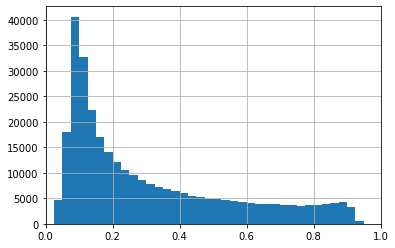

In [34]:
df_f['smooth-or-featured_featured-or-disk_fraction'].hist(bins=40, range=[0., 1.])
plt.xlim(0., 1.)

In [35]:
df_f.to_csv('results/temp/decals_n2_allq_m0_all_first.csv', index=False)